In [ ]:
!pip install gymnasium

# Définition de l'environnement


In [11]:
import random
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import string

class HangedManEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "n_total_try_games": 11}

    """Gym environnement for the Hanged Man game.

    Args:
        max_word_size (int): maximum size of the word to be guessed
        word_dictionary (set): Dictionary of words

    Attributes:
        max_word_size (int): maximum size of the word to be guessed
        n_total_try_games (int): Maximum number of try
        word_dictionary (set): Dictionary of words
        encoded_state (np.array int): Current state encoded.
        encoded_tried_letters (np.array bool):
        encoded_aim (np.array int): Current word to guess encoded. When the encoded
        state reach this aim, the game ends.
    """

    def __init__(self, word_dictionary, max_word_size=8, render_mode = None):

        # Specifics attributes
        self.n_total_try_games = self.metadata["n_total_try_games"]
        self.encoded_state = None
        self.encoded_aim = None
        self.encoded_tried_letters = None
        self._nb_left_try = None  # number of try left
        self.word_dictionary = word_dictionary
        self.max_word_size = max_word_size

        # Action Space
        # The agent can choose between all letter.
        self.action_space = spaces.Discrete(26)

        # Observations Space
        # 28 states for each position in the word
        # 26 for each letter of the alphabet.
        # 1 for "to be guessed" (represented as _).
        # 1 for "not active in this game" (represented as a padding).
        self.observation_space = spaces.Tuple((
            spaces.MultiDiscrete([28] * self.max_word_size),  # Encoded word
            spaces.MultiBinary(26)  # Binary status for letters
        ))

        self.render_mode = render_mode
        assert render_mode is None or render_mode in self.metadata["render_modes"]

        self.window = None
        self.clock = None

    def encode_word(self, word):
        """Convert word string to encoded numpy array."""
        encoded = np.zeros(self.max_word_size, dtype=np.int8)

        for idx, char in enumerate(word):
            if char == '_':
                encoded[idx] = 1
            else:
                encoded[idx] = ord(char) - ord('A') + 2

        return encoded

    def decode_word(self, encoded_word):
        """Convert numpy array back to word string."""
        decoded = ""

        for code in encoded_word:
            if code == 0:
                break
            elif code == 1:
                decoded = decoded + "_"
            else:
                decoded = decoded + chr(code + ord('A') - 2)
        return decoded

    def decode_tried_letters(self):
        """"Decode encoded letters for human rendering"""
        tried_letters = set()

        for index, tried in enumerate(self.encoded_tried_letters):
            if tried:
                letter = chr(index + ord('A'))
                tried_letters.add(letter)

        return tried_letters

    def _get_obs(self):
        """" Get observation """
        return (self.encoded_state, self.encoded_tried_letters)

    def _get_info(self):
        """" Get info """
        info = {'left try': self._nb_left_try}
        return info

    def reset(self, seed=None):
        """
        Set or reset the environment attributes to start a new episode
        """
        super().reset(seed=seed)

        # Observations Space
        # Set encodes states with all elements inactive (=0)
        self.encoded_state = np.zeros((self.max_word_size), dtype = np.uint8)
        # Sample a word from dict
        decoded_word = self._sample_word()
        # Set up active elements in encoded state
        for i in range(0, len(decoded_word)):
            self.encoded_state[i] = 1
        # Encode the word that will be the aim for the encoded state
        self.encoded_aim = self.encode_word(decoded_word)
        # a bool array to know which letters have been tried
        self.encoded_tried_letters = np.zeros((26), dtype = np.bool_)
        # Set the nb_left_try
        self._nb_left_try = self.n_total_try_games

        if self.render_mode == "human":
            self.render()

        return self._get_obs(), self._get_info()

    def step(self, action):
        """" Process the game, maximize the encoded stuff for performance"""

        reward = -1 # negative reward because the aim to to win the fastest
        # if a letter is found then the reward will be 0 for the step

        # check if letter already tried
        if not self.encoded_tried_letters[action]:
            self.encoded_tried_letters[action] = True
            encoded_letter = action + 2
            # Find the indices in encoded_aim where the letter is present
            letter_indices = np.where(self.encoded_aim == encoded_letter)[0]
            # If indices are found (letter exists in encoded_aim)
            if len(letter_indices) > 0:
                # Update the encoded_state at these indices
                self.encoded_state[letter_indices] = encoded_letter
                # Set reward to zero if letter found
                reward = 0

        self._nb_left_try += reward

        # Terminated ?
        terminated = False
        if self._nb_left_try == 0:
            terminated = True
        elif (self.encoded_state == self.encoded_aim).all(): # aim is reached
            terminated = True

        truncated = False  # often time limit

        if self.render_mode == "human":
            self.render()

        return self._get_obs(), reward, terminated, truncated, self._get_info()

    def render(self):
        print("-------------------------")
        print("Guessed word  : " + self.decode_word(self.encoded_state))
        print("Tried letters : " + str(self.decode_tried_letters()))

    def _sample_word(self):
        """" Sample a word """
        word = random.choice(self.word_dictionary)
        while len(word) > self.max_word_size:
            word = random.choice(self.word_dictionary)
        return word.upper()



# Appel un env.

In [12]:
import nltk
nltk.download('words')
from nltk.corpus import words
word_list = words.words()  # this returns a list
max_length = 3
filtered_words = [word for word in word_list if len(word) <= max_length]
env = HangedManEnv(filtered_words, max_length)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


# La partie apprentissage

## Définission d'une policy

In [10]:
import numpy as np

# Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
initial_epsilon = 1.0
epsilon_decay = 0.9975
min_epsilon = 0.05

# Initialize the Q-table
# The shape is based on the observation space and action space
q_table_shape = (28**max_length, 26)  # Adjust based on the state and action space
q_table = np.zeros(q_table_shape)

def epsilon_greedy_policy(state):
    """
    Returns an action based on epsilon-greedy policy.
    """
    if np.random.uniform(0, 1) < epsilon:
        # Exploration: choose a random action
        return np.random.choice(26)
    else:
        # Exploitation: choose the action with max Q-value for the current state
        # Mask forbidden actions using the second element of the observation
        masked_q_values = np.copy(q_table[state[0]])
        # Mask by setting very low Q-value for letter already tried
        masked_q_values[state[1]] = -np.inf
        # retrun the action with the max Q-value
        return np.argmax(masked_q_values)

## Entrainement

In [13]:
# Training loop
# Training parameters
total_episodes = 100000
batch_size = 500  # Number of episodes in a batch
n_tests = 500  # Number of evaluation runs after each batch
batch_rewards = []

epsilon = initial_epsilon # epsilon will update after each batch

# Train per batches
# epsilon decay after batch
# tests after batch
for batch in range(total_episodes // batch_size):
    # Training episodes
    batch_reward_sum = 0
    for episode in range(batch_size):

        state, _ = env.reset()

        # Convert state to a single integer for indexing in Q-table
        state_index = np.dot(state[0], [28**i for i in range(max_length)])

        done = False
        while not done:
            # action is determined with epsilon greedy policy
            # either exploratory or best according to current q-table
            action = epsilon_greedy_policy((state_index, state[1]))
            next_state, reward, done, _, _ = env.step(action)

            # Convert next_state to a single integer for indexing in Q-table
            next_state_index = np.dot(next_state[0], [28**i for i in range(max_length)])

            # Q-learning update rule
            best_next_action = np.argmax(q_table[next_state_index])
            td_target = reward + discount_factor * q_table[next_state_index][best_next_action]
            td_error = td_target - q_table[state_index][action]
            q_table[state_index][action] += learning_rate * td_error

            state = next_state
            state_index = next_state_index


    epsilon *= epsilon_decay
    epsilon = max(epsilon, min_epsilon)

    # Evaluation after each batch
    total_test_rewards = []
    for _ in range(n_tests):
        state, _ = env.reset()
        state_index = np.dot(state[0], [28**i for i in range(max_length)])
        total_reward = 0
        done = False
        while not done:
            # Always choose the best possible action
            # Same as using the policy with epsilon = 0
            masked_q_values = np.copy(q_table[state_index])
            masked_q_values[state[1]] = -np.inf
            action = np.argmax(masked_q_values)
            state, reward, done, _, _ = env.step(action)
            state_index = np.dot(state[0], [28**i for i in range(max_length)])
            total_reward += reward

        total_test_rewards.append(total_reward)
    #
    mean_test_reward = np.mean(total_test_rewards)
    batch_rewards.append(mean_test_reward)


In [ ]:
epsilon

0.05

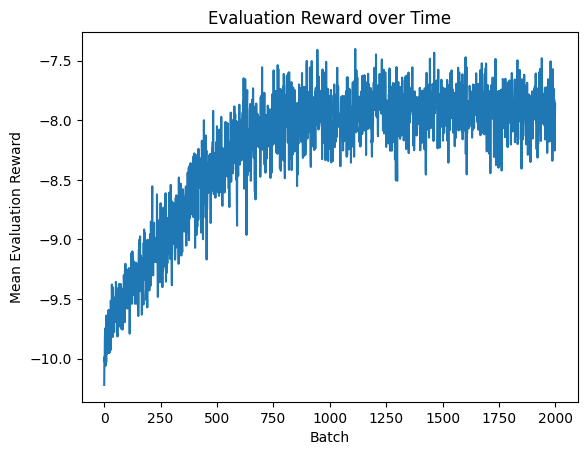

In [ ]:
import matplotlib.pyplot as plt

# Plotting
plt.plot(batch_rewards)
plt.xlabel('Batch')
plt.ylabel('Mean Evaluation Reward')
plt.title('Evaluation Reward over Time')
plt.show()